In [44]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
np.random.seed(1000)

In [45]:
file_path = "S_plasample_cube_40.txt"
datasets = []
current_dataset = []
with open(file_path, 'r') as file:
    for line in file:
        if line.startswith("#Parameters"):
            if current_dataset:
                datasets.append(current_dataset)
                current_dataset = []
            params_str = line[line.index("{")+1:line.index("}")]
            params = dict(param.split('=') for param in params_str.split(';'))
            current_dataset.append(params)
        elif line.startswith("#"):
            continue
        else:
            data = line.strip().split('\t')
            current_dataset.append(data)
if current_dataset:
    datasets.append(current_dataset)
for i, dataset in enumerate(datasets):
    permittivity_values = dataset[0]
    df_data = dataset[1:]
    df = pd.DataFrame(df_data, columns=["Frequency", "Real", "Imaginary"])
    print(f"Dataset {i+1} - Permittivity values:")
    for key, value in permittivity_values.items():
        print(f"{key}: {value}")
    print("Data:")
    print(df)
    print()

Dataset 1 - Permittivity values:
vshift: -21.275
 cc: 40
 bb: 40
 aa: 40
 erpla1: 0.0041269841269841
 erpla: 3.15
 L1: 67
 L2: 32
 L22: 60
 L3: 34.5
 a1: -110.3314
 a2: 110.3314
 b1: -28.048
 b2: 110.3821
 c1: 0
 c2: 11.9761
 d1: -82.55
 d2: 82.55
 e1: 0
 e2: 82.3341
 er1: 2.55
 er11: 2.55
 h1: 14
 h22: 14
 h33: 28.5
 r0: 10.38125
 r00: 13
 r1: 8.001
 r11: 10.5
 r2: 2.09
 r22: 4.5
 r3: 7.653
 r33: 17
 r44: 2.75
 th1: 4.7625
 th11: 4.7625
 th2: 4.7625
 umax: 82.55
 umin1: -87.3125
 umin2: -82.55
 vmax: 87.0966
 vmin: 82.55
 vmin1: -4.7625
 vmin2: 87.0966
 wmax: 138.1125
 wx: 165.1
 wx2: 220.662
 wx_2: 174.625
 wx_21: 220.6628
 wx_22: 165.1
 wy: 82.55
 wy2: 138.43
 wy_2: 91.8591
 wy_21: 138.4301
 wy_22: 82.3341
 wz: 1000
 wz2: 12
 wz_2: 209.55
 wz_21: 14
 wz_22: 204.01
 zshift: 101
 zshift1: 154
Data:
            Frequency                Real          Imaginary
0     1.0000000000000  -0.079316847026348   0.32380053400993
1     1.0010000467300  -0.065709270536900   0.32323741912842
2     

In [22]:
mat = scipy.io.loadmat('data.mat')
out_data = mat['out_data']
df = pd.DataFrame(out_data)
df.columns = ['frequency','permittivity_real','permittivity_imaginary','s11_real','s11_imaginary']
print(df.head(20))

    frequency  permittivity_real  permittivity_imaginary  s11_real   
0       1.199           2.572762                0.064912 -0.003002  \
1       1.199           3.008671                0.073172 -0.003481   
2       1.199           5.928357                0.064775 -0.006756   
3       1.199           4.786311                0.045092 -0.006433   
4       1.199           3.813276                0.054701 -0.005164   
5       1.199           7.646629                0.029632 -0.008666   
6       1.199           5.682113                0.074469 -0.006294   
7       1.199           5.397789                0.018896 -0.007740   
8       1.199           8.337549                0.068678 -0.007830   
9       1.199           3.286712                0.018351 -0.005592   
10      1.199           7.057602                0.036848 -0.008175   
11      1.199           7.029833                0.062562 -0.007415   
12      1.199           4.043567                0.078023 -0.004763   
13      1.199       

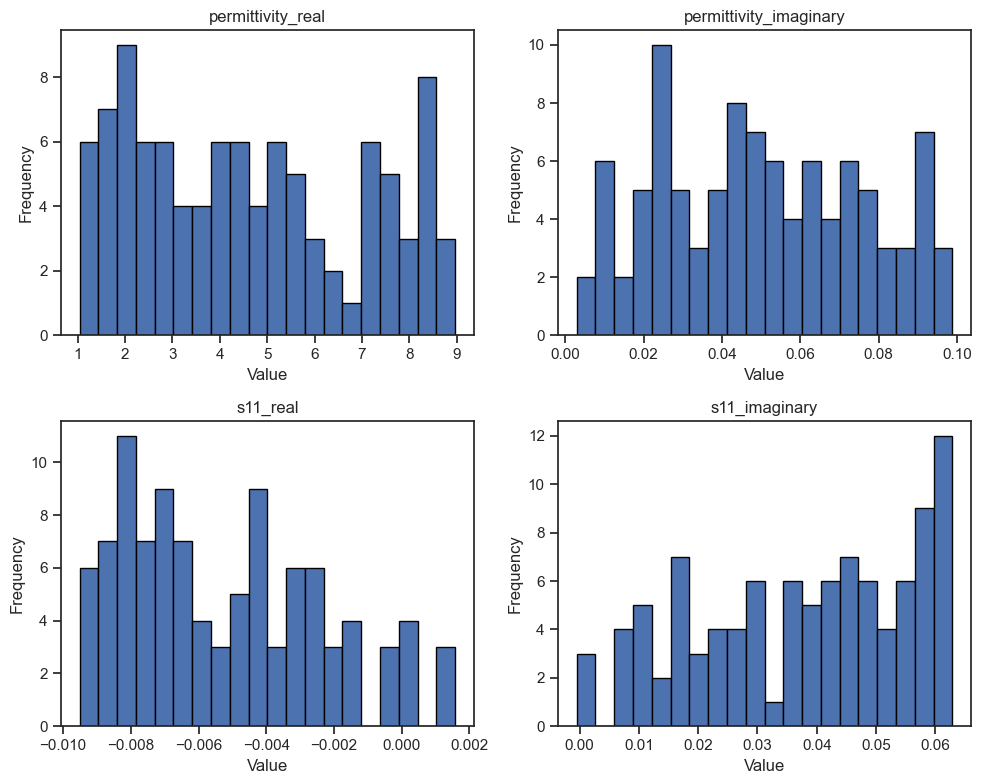

In [23]:
columns = ['permittivity_real', 'permittivity_imaginary', 's11_real', 's11_imaginary']
plt.figure(figsize=(10, 8))
for i, column in enumerate(columns):
    plt.subplot(2, 2, i+1)
    plt.hist(df[column], bins=20, edgecolor='black')
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

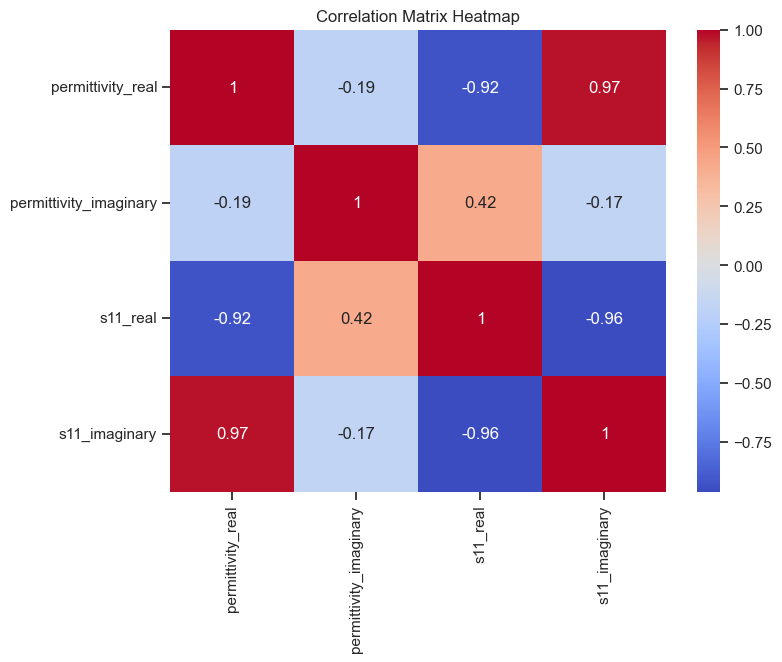

In [24]:
plt.figure(figsize=(8, 6))
sns.heatmap(df[['permittivity_real','permittivity_imaginary','s11_real','s11_imaginary']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

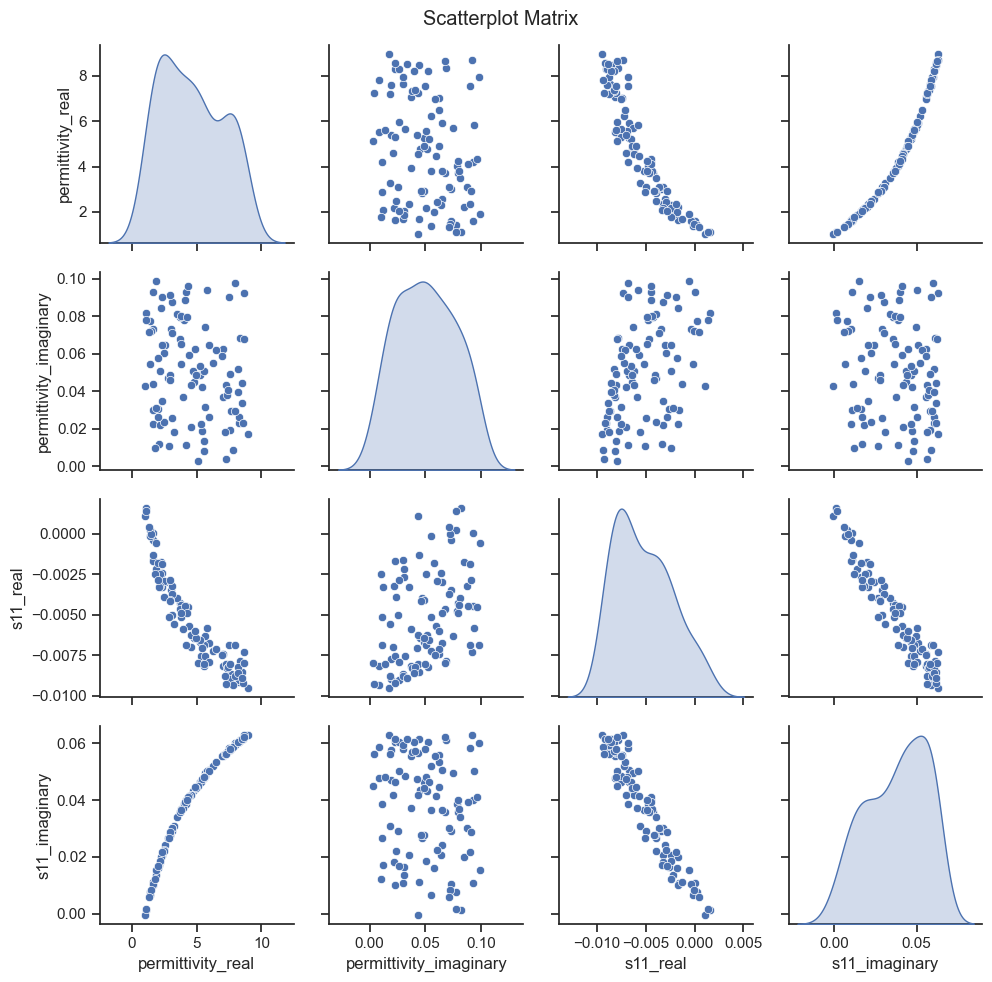

In [26]:
sns.set(style="ticks")
sns.pairplot(df[columns], diag_kind="kde")
plt.suptitle('Scatterplot Matrix')
plt.tight_layout()
plt.show()

In [27]:
from sklearn.preprocessing import MinMaxScaler
X_norm = MinMaxScaler().fit(df[columns])
df[columns] =  X_norm.transform(df[columns])

In [28]:
X = df[['s11_real', 's11_imaginary']].values
y = df[['permittivity_real', 'permittivity_imaginary']].values

In [29]:
indices = np.random.permutation(len(X))
X = X[indices]
y = y[indices]
split_point = int(0.80 * len(X))
X_train = X[:split_point]
y_train = y[:split_point]
X_val = X[split_point:]
y_val = y[split_point:]

In [30]:
X_train.shape

(80, 2)

In [31]:
y_train.shape

(80, 2)

In [32]:
X_val.shape

(20, 2)

In [33]:
y_val.shape

(20, 2)

In [34]:
def mae_loss(y_true, y_pred):
    y_true_real, y_true_imag = tf.split(y_true, 2, axis=-1)
    y_pred_real, y_pred_imag = tf.split(y_pred, 2, axis=-1)
    loss_real = tf.losses.mean_absolute_error(y_true_real, y_pred_real)
    loss_imag = tf.losses.mean_absolute_error(y_true_imag, y_pred_imag)
    return loss_real + loss_imag
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(y.shape[1], activation='linear')
])
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001),
              loss=[mae_loss],
              metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError()])


In [35]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               384       
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 16)                528       
                                                                 
 dense_10 (Dense)            (None, 2)                 34        
                                                                 
Total params: 11282 (44.07 KB)
Trainable params: 11282 (44.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/500
80/80 [==============================] - 0s 1ms/step - loss: 0.9662 - mean_absolute_error: 0.4831 - mean_squared_error: 0.3150 - val_loss: 0.7887 - val_mean_absolute_error: 0.3944 - val_mean_squared_error: 0.2413
Epoch 2/500
80/80 [==============================] - 0s 632us/step - loss: 0.8705 - mean_absolute_error: 0.4353 - mean_squared_error: 0.2667 - val_loss: 0.6967 - val_mean_absolute_error: 0.3484 - val_mean_squared_error: 0.2005
Epoch 3/500
80/80 [==============================] - 0s 828us/step - loss: 0.7766 - mean_absolute_error: 0.3883 - mean_squared_error: 0.2223 - val_loss: 0.5828 - val_mean_absolute_error: 0.2914 - val_mean_squared_error: 0.1530
Epoch 4/500
80/80 [==============================] - 0s 624us/step - loss: 0.6440 - mean_absolute_error: 0.3220 - mean_squared_error: 0.1680 - val_loss: 0.4478 - val_mean_absolute_error: 0.2239 - val_mean_squared_error: 0.1022
Epoch 5/500
80/80 [==============================] - 0s 604us/step - loss: 0.4899 - mean_absol

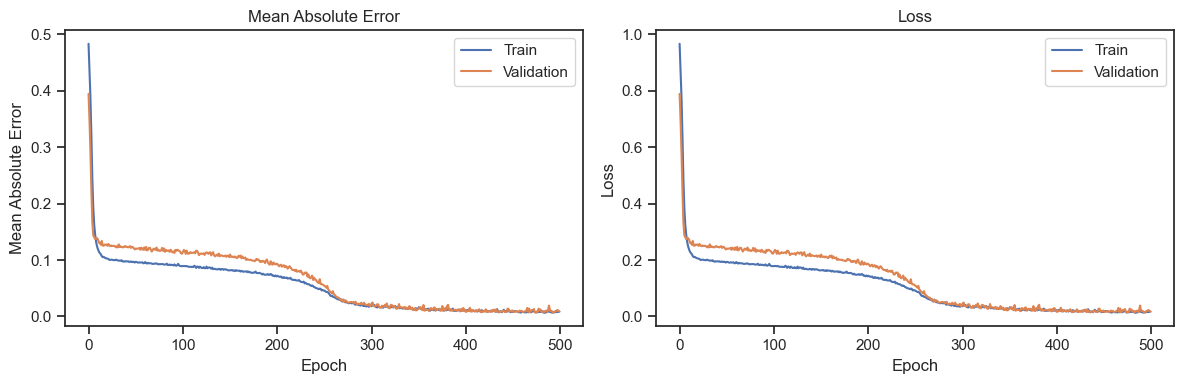

In [36]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=1)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend(['Train', 'Validation'])
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 31ms/step


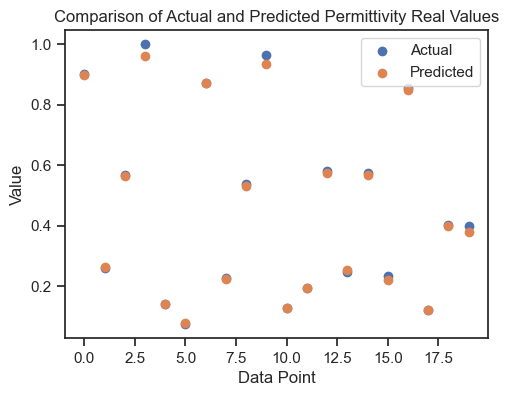

In [37]:
y_pred = model.predict(X_val)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(range(len(y_val)), y_val[:, 0], label='Actual')
plt.scatter(range(len(y_pred)), y_pred[:, 0], label='Predicted')
plt.title('Comparison of Actual and Predicted Permittivity Real Values')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend()

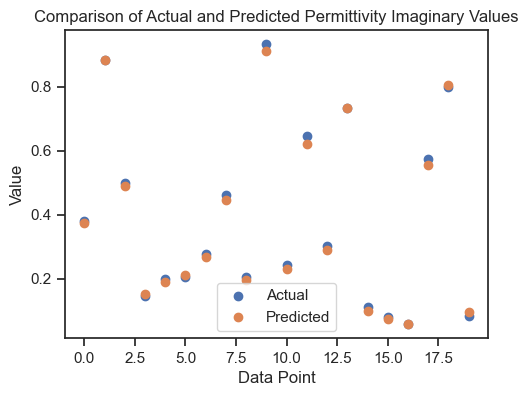

In [38]:

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(range(len(y_val)), y_val[:, 1], label='Actual')
plt.scatter(range(len(y_pred)), y_pred[:, 1], label='Predicted')
plt.title('Comparison of Actual and Predicted Permittivity Imaginary Values')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend()

In [39]:
actual_matrix = np.concatenate((y_val, X_val), axis=1)
actual_matrix

array([[0.90309549, 0.38205002, 0.08239351, 0.96085748],
       [0.26055162, 0.88314178, 0.56625674, 0.48656586],
       [0.56902588, 0.49990354, 0.2369927 , 0.77025424],
       [1.        , 0.14757344, 0.        , 1.        ],
       [0.14211264, 0.20080741, 0.56653862, 0.29417597],
       [0.07417173, 0.2069795 , 0.70786938, 0.1671869 ],
       [0.87207015, 0.2789594 , 0.06473612, 0.94455189],
       [0.22626589, 0.46070161, 0.49816443, 0.4291614 ],
       [0.53828335, 0.20516203, 0.17630155, 0.74138229],
       [0.96546988, 0.93261896, 0.19726756, 0.99900686],
       [0.12843067, 0.24265769, 0.60181887, 0.27138811],
       [0.19360659, 0.64655814, 0.58702646, 0.38686334],
       [0.58000008, 0.3020125 , 0.17929536, 0.77421208],
       [0.24856229, 0.73271814, 0.54387898, 0.46732029],
       [0.57546554, 0.11194946, 0.13159896, 0.76728042],
       [0.23211858, 0.0808768 , 0.39677192, 0.42881087],
       [0.85566966, 0.0587169 , 0.01460309, 0.9327972 ],
       [0.11970212, 0.57293149,

In [40]:
predicted_matrix = np.concatenate((y_pred, X_val), axis=1)
predicted_matrix

array([[0.89928663, 0.37481371, 0.08239351, 0.96085748],
       [0.26502752, 0.88195401, 0.56625674, 0.48656586],
       [0.56331384, 0.49057788, 0.2369927 , 0.77025424],
       [0.96242285, 0.15364215, 0.        , 1.        ],
       [0.14214271, 0.1911198 , 0.56653862, 0.29417597],
       [0.07752538, 0.21173608, 0.70786938, 0.1671869 ],
       [0.87133831, 0.26827613, 0.06473612, 0.94455189],
       [0.22494236, 0.44729662, 0.49816443, 0.4291614 ],
       [0.53018874, 0.19677956, 0.17630155, 0.74138229],
       [0.93536305, 0.91222173, 0.19726756, 0.99900686],
       [0.129347  , 0.23122174, 0.60181887, 0.27138811],
       [0.19466971, 0.62230408, 0.58702646, 0.38686334],
       [0.57461226, 0.29015556, 0.17929536, 0.77421208],
       [0.25221705, 0.73222548, 0.54387898, 0.46732029],
       [0.56853938, 0.10007745, 0.13159896, 0.76728042],
       [0.22100313, 0.07365838, 0.39677192, 0.42881087],
       [0.84830081, 0.05817399, 0.01460309, 0.9327972 ],
       [0.12128346, 0.55480433,

In [41]:
actual_matrix = X_norm.inverse_transform(actual_matrix)
predicted_matrix = X_norm.inverse_transform(predicted_matrix)

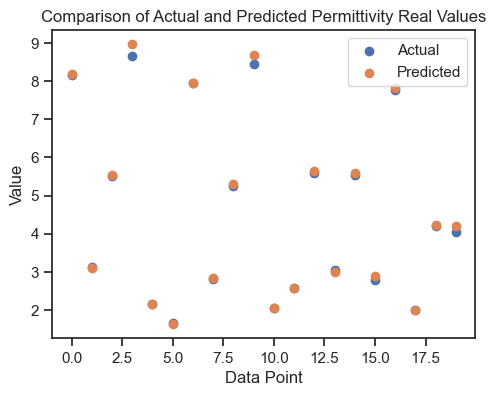

In [42]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(range(len(y_val)), predicted_matrix[:, 0], label='Actual')
plt.scatter(range(len(y_pred)), actual_matrix[:, 0], label='Predicted')
plt.title('Comparison of Actual and Predicted Permittivity Real Values')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend()

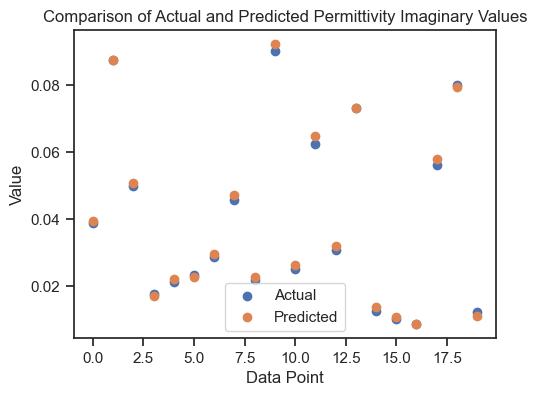

In [43]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(range(len(y_val)), predicted_matrix[:, 1], label='Actual')
plt.scatter(range(len(y_pred)), actual_matrix[:, 1], label='Predicted')
plt.title('Comparison of Actual and Predicted Permittivity Imaginary Values')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend()